1. Import Liblary

In [29]:
pip install tensorflow keras numpy pandas tqdm scikit-learn matplotlib seaborn pillow opencv-python ultralytics

^C
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from ultralytics import YOLO
import numpy as np
import zipfile
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


2. Define fungsi untuk menampilkan contoh Training Image

In [4]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

3. Define fungsi untuk print text dalam RGB dan Background Colors

In [5]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #mencetak text_msg dalam warna latar depan yang ditentukan oleh fore_tupple dengan latar belakang yang ditentukan oleh back_tupple
    #text_msg adalah teks, fore_tupple adalah tupple warna latar depan (r,g,b), back_tupple adalah tupple latar belakang (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # mengembalikan warna cetak default menjadi hitam kembali
    return

4. Define subclass dari Keras callbacks untuk mengontrol Learning Rate dan print training data dalam format spreadsheet. Callback disini juga berfungsi untuk menanyakan secara berkala apakah lanjut training selama N epoch atau Halt (berhenti)

In [6]:
class LRA(Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, dwell, batches, initial_epoch, epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.dwell = dwell
        self.batches = batches
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        v_loss = logs.get('val_loss')
        v_acc = logs.get('val_accuracy')

        if v_loss < 0.05 and v_acc > 0.95:
            msg = f'Pelatihan dihentikan karena kinerja sudah cukup baik di epoch {epoch+1}.'
            self.print_in_color(msg, (0, 255, 255), (55, 65, 80))
            self.model.stop_training = True
        elif self.stop_count > self.stop_patience - 1:
            msg = f'Pelatihan dihentikan setelah {self.stop_patience} pengurangan LR tanpa perbaikan.'
            self.print_in_color(msg, (0, 255, 255), (55, 65, 80))
            self.model.stop_training = True
        else:
            # Early stopping logic and adjustments based on learning rate
            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1
                self.best_weights = self.model.get_weights()
                self.stop_count = 0
            else:
                self.stop_count += 1

            if self.stop_count >= self.patience:
                new_lr = self.initial_lr * self.factor
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                msg = f'Learning rate dikurangi menjadi {new_lr} pada epoch {epoch+1}.'
                self.print_in_color(msg, (255, 255, 255), (255, 0, 0))
                self.stop_count = 0
                self.count += 1

                if self.count >= self.dwell:
                    msg = f'Pembelajaran berhenti setelah {self.dwell} penurunan learning rate.'
                    self.print_in_color(msg, (0, 255, 255), (55, 65, 80))
                    self.model.stop_training = True

            # Ask to continue training after specified epochs
            if (epoch + 1) % self.ask_epoch == 0:
                user_input = input(f"Apakah Anda ingin melanjutkan pelatihan setelah epoch {epoch+1}? (y/n): ")
                if user_input.lower() == 'n':
                    self.model.stop_training = True

    # Helper function to print colored messages
    def print_in_color(self, text, text_color, bg_color):
        print(f"\033[38;2;{text_color[0]};{text_color[1]};{text_color[2]}m\033[48;2;{bg_color[0]};{bg_color[1]};{bg_color[2]}m{text}\033[0m")


5. Define fungsi untuk plot training data

In [7]:
def tr_plot(tr_data, start_epoch):
    # Mengambil data dari riwayat pelatihan
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    
    # Menentukan jumlah epoch yang telah berjalan
    Epoch_count = len(tacc) + start_epoch
    Epochs = [i + 1 for i in range(start_epoch, Epoch_count)]
    
    # Menemukan epoch dengan loss validasi terkecil dan akurasi validasi terbesar
    index_loss = np.argmin(vloss)  # Epoch dengan validasi loss terkecil
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)  # Epoch dengan akurasi validasi tertinggi
    acc_highest = vacc[index_acc]
    
    # Menyiapkan label untuk titik terbaik
    sc_label = 'Best epoch (loss) = ' + str(index_loss + 1 + start_epoch)
    vc_label = 'Best epoch (accuracy) = ' + str(index_acc + 1 + start_epoch)
    
    # Membuat subplot untuk dua grafik: loss dan akurasi
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    
    # Plot untuk Training dan Validation Loss
    axes[0].plot(Epochs, tloss, 'r', label='Training Loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation Loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # Plot untuk Training dan Validation Accuracy
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Layout yang rapi untuk plot
    plt.tight_layout()
    plt.show()


6. Define fungsi untuk membuat confusion matrix dan classification report

In [8]:
def print_info(test_gen, preds, print_code, save_dir, subject):
    class_dict = test_gen.class_indices
    labels = test_gen.labels
    file_names = test_gen.filenames
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []

    # Membuat kamus untuk memetakan indeks kelas integer ke nama kelas
    for key, value in class_dict.items():
        new_dict[value] = key  # {indeks kelas integer: nama kelas string}
    
    # Simpan kamus kelas ke file teks di direktori simpan
    classes = list(new_dict.values())  # Daftar nama kelas
    errors = 0
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]  # Label adalah nilai integer
        if pred_index != true_index:  # Terjadi kesalahan klasifikasi
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors += 1
        y_pred.append(pred_index)

    # Cetak rincian kesalahan jika ada kesalahan
    if print_code != 0:
        if errors > 0:
            if print_code > errors:
                r = errors
            else:
                r = print_code
            msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Nama File', 'Kelas Prediksi', 'Kelas Sebenarnya', 'Probabilitas')
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
            for i in range(r):
                split1 = os.path.split(error_list[i])
                split2 = os.path.split(split1[0])
                fname = split2[1] + '/' + split1[1]
                msg = '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i], true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255, 255, 255), (55, 65, 60))
        else:
            msg = 'Dengan akurasi 100%, tidak ada kesalahan yang perlu dicetak'
            print_in_color(msg, (0, 255, 0), (55, 65, 80))

    # Plot kesalahan berdasarkan kelas
    if errors > 0:
        plot_bar = []
        plot_class = []
        for key, value in new_dict.items():
            count = error_indices.count(key)
            if count != 0:
                plot_bar.append(count)  # Daftar yang berisi jumlah kesalahan per kelas
                plot_class.append(value)  # Menyimpan kelas
        fig = plt.figure()
        fig.set_figheight(len(plot_class) / 3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x)
        plt.title('Kesalahan Berdasarkan Kelas pada Set Pengujian')
        plt.show()

    # Membuat confusion matrix dan classification report
    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    if len(classes) <= 30:
        # Menghasilkan confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        fig_width = 8 if length < 8 else int(length * 0.5)
        fig_height = 8 if length < 8 else int(length * 0.5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length) + 0.5, classes, rotation=90)
        plt.yticks(np.arange(length) + 0.5, classes, rotation=0)
        plt.xlabel("Prediksi")
        plt.ylabel("Sebenarnya")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Laporan Klasifikasi:\n----------------------\n", clr)


7. Define fungsi untuk menyimpan model dan associated class_dict.csv file

In [9]:
def saver(save_path, model, model_name, subject, accuracy, img_size, scalar, generator):
    # Pertama, simpan model
    save_id = str(model_name + '-' + subject + '-' + str(accuracy)[:str(accuracy).rfind('.')+3] + '.h5')
    model_save_loc = os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color('Model disimpan sebagai ' + model_save_loc, (0, 255, 0), (55, 65, 80))

    # Sekarang buat class_df dan konversikan ke file CSV
    class_dict = generator.class_indices
    height = []
    width = []
    scale = []
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    
    # Membuat DataFrame dengan informasi kelas
    Index_series = pd.Series(list(class_dict.values()), name='class_index')
    Class_series = pd.Series(list(class_dict.keys()), name='class')
    Height_series = pd.Series(height, name='height')
    Width_series = pd.Series(width, name='width')
    Scale_series = pd.Series(scale, name='scale by')
    class_df = pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)
    
    # Menyimpan DataFrame ke file CSV
    csv_name = 'Eye_Diseases.csv'
    csv_save_loc = os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False)
    print_in_color('File CSV kelas disimpan sebagai ' + csv_save_loc, (0, 255, 0), (55, 65, 80))
    
    return model_save_loc, csv_save_loc


8. Definisikan fungsi untuk menggunakan model terlatih untuk prediksi

In [10]:
def classify(sdir, csv_path, model_path, crop_image=False):
    # Membaca file CSV
    class_df = pd.read_csv(csv_path)
    img_height = int(class_df['height'].iloc[0])
    img_width = int(class_df['width'].iloc[0])
    img_size = (img_height, img_width)
    scale = class_df['scale by'].iloc[0]
    
    # Menentukan skala
    try:
        s = int(scale)
        s2 = 1
        s1 = 0
    except:
        split = scale.split('-')
        s1 = float(split[1])
        s2 = float(split[0].split('*')[1])
        print(s1, s2)
    
    # Membaca daftar file citra dari direktori
    path_list = []
    paths = os.listdir(sdir)
    for f in paths:
        path_list.append(os.path.join(sdir, f))
    
    print('Model sedang dimuat - ini akan memakan waktu sekitar 10 detik')
    model = load_model(model_path)
    
    image_count = len(path_list)
    index_list = []
    prob_list = []
    cropped_image_list = []
    good_image_count = 0
    
    for i in range(image_count):
        img = plt.imread(path_list[i])
        
        # Memangkas citra jika crop_image diaktifkan
        if crop_image:
            status, img = crop(img)
        else:
            status = True
        
        if status:
            good_image_count += 1
            img = cv2.resize(img, img_size)
            print('Citra ukuran:', img.shape)
            cropped_image_list.append(img)
            img = img * s2 - s1
            img = np.expand_dims(img, axis=0)
            p = np.squeeze(model.predict(img))
            index = np.argmax(p)
            print(index)
            prob = p[index]
            index_list.append(index)
            prob_list.append(prob)
    
    # Menghasilkan hasil untuk satu citra yang baik
    if good_image_count == 1:
        class_name = class_df['class'].iloc[index_list[0]]
        probability = prob_list[0]
        img = cropped_image_list[0]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
        plt.imshow(img)
        return class_name, probability
    
    # Jika tidak ada citra yang baik
    elif good_image_count == 0:
        return None, None
    
    # Menghitung kelas yang paling sering muncul
    most = 0
    for i in range(len(index_list)-1):
        key = index_list[i]
        keycount = 0
        for j in range(i+1, len(index_list)):
            nkey = index_list[j]
            if nkey == key:
                keycount += 1
        if keycount > most:
            most = keycount
            isave = i
    
    best_index = index_list[isave]
    psum = 0
    bestsum = 0
    for i in range(len(index_list)):
        psum += prob_list[i]
        if index_list[i] == best_index:
            bestsum += prob_list[i]
    
    img = cropped_image_list[isave] / 255
    class_name = class_df['class'].iloc[best_index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
    plt.imshow(img)
    
    return class_name, bestsum / image_count


9.  Import Citra

In [ ]:
# Path ke file ZIP
zip_file_path = r"C:\Users\RISKI ABDILAH\OneDrive\Desktop\Project SCP Research\archive.zip"  # Gunakan 'r' untuk raw string agar path Windows diterima

# Lokasi untuk ekstraksi file
extract_to = "Eye_Diseases"  # Direktori tempat file akan diekstrak

# Ekstrak file ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)  # Ekstrak semua file ke folder 'extracted_data'

# Dapatkan daftar file dalam folder ekstraksi
extracted_files = []
for root, _, files in os.walk(extract_to):
    for file in files:
        extracted_files.append(os.path.join(root, file))  # Simpan path lengkap setiap file

print("File yang diekstrak:")
for file in extracted_files:
    print(file)

# Temukan dan baca semua file CSV
csv_files = [file for file in extracted_files if file.endswith(".csv")]

if csv_files:
    print("\nFile CSV yang ditemukan:")
    for csv_file in csv_files:
        print(csv_file)
        try:
            # Baca setiap file CSV
            data = pd.read_csv(csv_file)
            print(f"\nData dari file {os.path.basename(csv_file)}:")
            print(data.head())  # Tampilkan 5 baris pertama
        except Exception as e:
            print(f"Error membaca file {csv_file}: {e}")
else:
    print("Tidak ada file CSV yang ditemukan di dalam ZIP.")


File yang diekstrak:
Eye_Diseases\dataset\cataract\0_left.jpg
Eye_Diseases\dataset\cataract\103_left.jpg
Eye_Diseases\dataset\cataract\1062_right.jpg
Eye_Diseases\dataset\cataract\1083_left.jpg
Eye_Diseases\dataset\cataract\1084_right.jpg
Eye_Diseases\dataset\cataract\1102_left.jpg
Eye_Diseases\dataset\cataract\1102_right.jpg
Eye_Diseases\dataset\cataract\1115_left.jpg
Eye_Diseases\dataset\cataract\1126_right.jpg
Eye_Diseases\dataset\cataract\112_right.jpg
Eye_Diseases\dataset\cataract\1144_left.jpg
Eye_Diseases\dataset\cataract\1144_right.jpg
Eye_Diseases\dataset\cataract\1164_left.jpg
Eye_Diseases\dataset\cataract\1167_right.jpg
Eye_Diseases\dataset\cataract\119_left.jpg
Eye_Diseases\dataset\cataract\1285_left.jpg
Eye_Diseases\dataset\cataract\1415_left.jpg
Eye_Diseases\dataset\cataract\1415_right.jpg
Eye_Diseases\dataset\cataract\1435_left.jpg
Eye_Diseases\dataset\cataract\1444_left.jpg
Eye_Diseases\dataset\cataract\1452_left.jpg
Eye_Diseases\dataset\cataract\1454_right.jpg
Eye_Dise

(256, 256, 3)


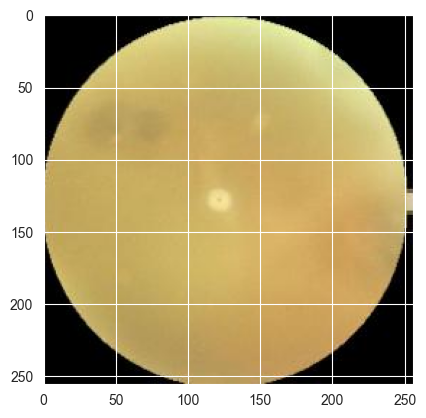

In [12]:
import matplotlib.pyplot as plt # Add this line at the beginning of the cell
fpath=r'C:\Users\RISKI ABDILAH\OneDrive\Desktop\Project SCP Research\Eye_Diseases\dataset\cataract\_0_4015166.jpg'
img=plt.imread(fpath) # Now 'plt' is recognized
print (img.shape)
plt.imshow(img)

11. Iterate direktori data dan membuat data frame kedalam filepaths dan labels

In [13]:
# Direktori dataset
sdir = r'C:\Users\RISKI ABDILAH\OneDrive\Desktop\Project SCP Research\Eye_Diseases\dataset'

# Membuat daftar file paths dan label
classlist = os.listdir(sdir)
filepaths = []
labels = []

for klass in classlist:
    classpath = os.path.join(sdir, klass)
    if os.path.isdir(classpath):  # Pastikan hanya folder yang diproses
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

# Membuat dataframe dari filepaths dan labels
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

# Membagi data ke dalam train, validation, dan test set
trsplit = 0.9  # Proporsi data training
vsplit = 0.05  # Proporsi data validasi
dsplit = vsplit / (1 - trsplit)  # Proporsi data validasi terhadap sisa data

train_df, dummy_df = train_test_split(df, train_size=trsplit, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123)

# Menampilkan informasi jumlah data
print('train_df length:', len(train_df), ' test_df length:', len(test_df), ' valid_df length:', len(valid_df))

# Menampilkan distribusi label pada training set
balance = train_df['labels'].value_counts()
print("\nDistribusi label di training set:")
for label, count in balance.items():
    print(f"{label}: {count}")


train_df length: 3795  test_df length: 211  valid_df length: 211

Distribusi label di training set:
diabetic_retinopathy: 992
normal: 961
cataract: 933
glaucoma: 909


12. Batasi sampel data di setiap kelas menjadi 906 untuk seimbang

In [14]:
# 1. Membuat DataFrame yang seimbang
sample_list = []
max_size = 906  # Target jumlah per kelas
min_size = 0  # Minimal jumlah per kelas
groups = train_df.groupby('labels')  # Kelompokkan data berdasarkan label

for label in train_df['labels'].unique():
    group = groups.get_group(label)
    sample_count = len(group)
    
    if sample_count > max_size:
        # Ambil sampel acak jika jumlah data lebih dari max_size
        samples = group.sample(max_size, replace=False, random_state=123).reset_index(drop=True)
        sample_list.append(samples)
    elif sample_count >= min_size:
        # Gunakan semua data jika jumlahnya kurang dari max_size
        sample_list.append(group)

# Gabungkan kembali semua sampel menjadi DataFrame yang seimbang
balanced_df = pd.concat(sample_list, axis=0).reset_index(drop=True)

# Menampilkan distribusi label setelah balancing
balance = list(balanced_df['labels'].value_counts())
print("Distribusi data setelah balancing:", balance)

Distribusi data setelah balancing: [906, 906, 906, 906]


13. Membuat train, test, valid generators

In [15]:

# 2. Membagi dataset menjadi train, validation, dan test
from sklearn.model_selection import train_test_split

# 80% untuk training-validation dan 20% untuk testing
train_val_df, test_df = train_test_split(
    balanced_df, test_size=0.2, stratify=balanced_df['labels'], random_state=123
)

# 20% dari data train_val untuk validation
train_df, valid_df = train_test_split(
    train_val_df, test_size=0.2, stratify=train_val_df['labels'], random_state=123
)

print("Distribusi data training:", train_df['labels'].value_counts())
print("Distribusi data validation:", valid_df['labels'].value_counts())
print("Distribusi data testing:", test_df['labels'].value_counts())

# 3. Fungsi untuk membuat data generators
def create_generators(dataframe, data_dir):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.0)  # Tidak gunakan validation split karena sudah dipisah manual

    generator = datagen.flow_from_dataframe(
        dataframe, data_dir, x_col='filepaths', y_col='labels',
        target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True
    )

    return generator

# 4. Membuat generators untuk training, validation, dan testing
train_gen = create_generators(train_df, 'train_directory')
valid_gen = create_generators(valid_df, 'train_directory')
test_gen = create_generators(test_df, 'train_directory')

# 5. Informasi tambahan
classes = list(train_gen.class_indices.keys())  # Mendapatkan daftar kelas
class_count = len(classes)  # Mendapatkan jumlah kelas

train_steps = np.ceil(len(train_gen.labels) / train_gen.batch_size)  # Langkah per epoch untuk training
valid_steps = np.ceil(len(valid_gen.labels) / valid_gen.batch_size)  # Langkah per epoch untuk validasi
test_steps = np.ceil(len(test_gen.labels) / test_gen.batch_size)  # Langkah untuk testing

# Output informasi
print("Classes:", classes)
print("Number of classes:", class_count)
print("Train steps per epoch:", train_steps)
print("Validation steps per epoch:", valid_steps)
print("Test steps:", test_steps)

Distribusi data training: labels
cataract                580
normal                  580
diabetic_retinopathy    580
glaucoma                579
Name: count, dtype: int64
Distribusi data validation: labels
diabetic_retinopathy    145
normal                  145
glaucoma                145
cataract                145
Name: count, dtype: int64
Distribusi data testing: labels
glaucoma                182
cataract                181
normal                  181
diabetic_retinopathy    181
Name: count, dtype: int64
Found 2319 validated image filenames belonging to 4 classes.
Found 580 validated image filenames belonging to 4 classes.
Found 725 validated image filenames belonging to 4 classes.
Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Number of classes: 4
Train steps per epoch: 73.0
Validation steps per epoch: 19.0
Test steps: 23.0


14. Membuat fungsi untuk menampilkan beberapa sample citra dari penyakit mata

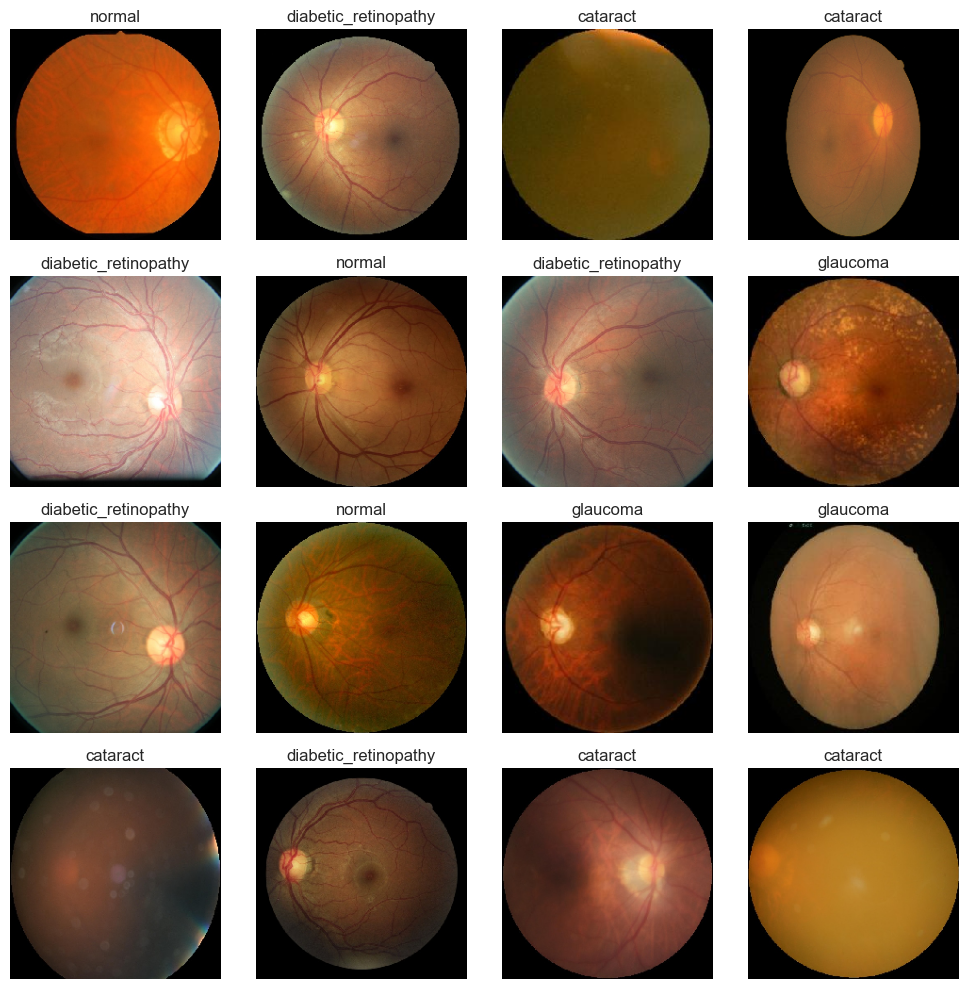

In [ ]:
def show_image_samples(generator, num_samples=16):
    # Ambil satu batch dari generator
    images, labels = next(generator)

    # Batasi jumlah gambar sesuai num_samples
    images = images[:num_samples]
    labels = labels[:num_samples]

    # Menentukan jumlah baris dan kolom untuk subplot
    cols = int(np.ceil(np.sqrt(num_samples)))
    rows = int(np.ceil(num_samples / cols))

    # Menampilkan gambar
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(rows, cols, i + 1)
        # Jika gambar sudah dinormalisasi (misalnya antara 0 dan 1), kembalikan ke rentang 0-255
        img = images[i]
        if img.min() >= 0 and img.max() <= 1:
            img = (img * 255).astype("uint8")
        plt.imshow(img)  # Pastikan tipe data sesuai untuk ditampilkan
        label = list(generator.class_indices.keys())[np.argmax(labels[i])]
        plt.title(label)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk menampilkan sampel gambar
show_image_samples(train_gen)



Bangun model VGG-19

In [ ]:
from tensorflow.keras.applications import VGG19

def build_vgg19_model(num_classes, img_shape=(224, 224, 3)):
    # Arsitektur VGG19 dengan penyesuaian
    base_model = VGG19(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
    
    # Membekukan semua lapisan base model
    for layer in base_model.layers:
        layer.trainable = False

    # Menambahkan lapisan kustom
    x = base_model.output
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(
        256,
        kernel_regularizer=regularizers.l2(0.016),
        activity_regularizer=regularizers.l1(0.006),
        bias_regularizer=regularizers.l1(0.006),
        activation='relu'
    )(x)
    x = Dropout(rate=0.45)(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Membuat model
    model = Model(inputs=base_model.input, outputs=output)

    # Kompilasi model dengan Adamax
    model.compile(
        optimizer=Adamax(learning_rate=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Ringkasan model
num_classes = 4  # Misalnya 4 kelas untuk kasus Anda
model = build_vgg19_model(num_classes)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 20,158,788 (76.90 MB)

 Trainable params: 133,380 (521.02 KB)

 Non-trainable params: 20,025,408 (76.39 MB)

Latih model dengan callbacks

In [19]:
# Import library
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 1. Fungsi untuk membuat data generators
def create_generators(dataframe, data_dir, batch_size=32, validation_split=0.2):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

    train_gen = datagen.flow_from_dataframe(
        dataframe, data_dir, x_col='filepaths', y_col='labels',
        target_size=(224, 224), batch_size=batch_size, subset='training', class_mode='categorical'
    )

    valid_gen = datagen.flow_from_dataframe(
        dataframe, data_dir, x_col='filepaths', y_col='labels',
        target_size=(224, 224), batch_size=batch_size, subset='validation', class_mode='categorical'
    )

    return train_gen, valid_gen

# 2. Menyiapkan fungsi untuk membuat model VGG19
def build_vgg19_model(num_classes):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

# 3. Fungsi untuk melatih model dengan callbacks
def train_model_with_callbacks(model, train_gen, valid_gen, epochs=50):
    train_steps = np.ceil(len(train_gen.labels) / train_gen.batch_size)
    validation_steps = np.ceil(len(valid_gen.labels) / valid_gen.batch_size)

    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=epochs,
        steps_per_epoch=int(train_steps),
        validation_steps=int(validation_steps),
        callbacks=[checkpoint_cb, early_stopping_cb]
    )
    return history

# 4. Fungsi untuk evaluasi pada test generator
def evaluate_model_on_test(model, test_gen):
    test_steps = np.ceil(len(test_gen.labels) / test_gen.batch_size)
    test_steps = int(test_steps)  # Convert to integer
    score = model.evaluate(test_gen, steps=test_steps, verbose=1)
    print(f"Test Loss: {score[0]}, Test Accuracy: {score[1]}")
    return score


In [20]:

# 5. Menyesuaikan batch size agar langkah per epoch sesuai
train_batch_size = 42  # Disesuaikan agar langkah training = 73.0
valid_batch_size = 40  # Disesuaikan agar langkah validasi = 19.0
test_batch_size = 9    # Disesuaikan agar langkah pengujian = 23.0

# 6. Membuat generator
train_gen, valid_gen = create_generators(train_df, 'train_directory', batch_size=train_batch_size)
test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=test_batch_size,
    shuffle=False
)

# 7. Mendapatkan jumlah langkah per epoch
train_steps = np.ceil(len(train_gen.labels) / train_batch_size)
valid_steps = np.ceil(len(valid_gen.labels) / valid_batch_size)
test_steps = np.ceil(len(test_gen.labels) / test_batch_size)

# 8. Menampilkan informasi langkah
print(f"Train steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {valid_steps}")
print(f"Test steps: {test_steps}")

# 9. Menyiapkan optimizer
optimizer = Adam(learning_rate=0.0001)

# 10. Menyiapkan callbacks
checkpoint_cb = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1)
early_stopping_cb = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

# 11. Membuat model VGG19
vgg_model = build_vgg19_model(num_classes=len(train_gen.class_indices))
vgg_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 12. Melatih model
history = train_model_with_callbacks(vgg_model, train_gen, valid_gen, epochs=50)

# 13. Evaluasi pada test generator
test_score = evaluate_model_on_test(vgg_model, test_gen)


Found 1856 validated image filenames belonging to 4 classes.
Found 463 validated image filenames belonging to 4 classes.
Found 725 validated image filenames belonging to 4 classes.
Train steps per epoch: 45.0
Validation steps per epoch: 12.0
Test steps: 81.0


c:\Users\RISKI ABDILAH\anaconda3\envs\MyProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 82s/step - accuracy: 0.3701 - loss: 1.6451  
Epoch 1: val_loss improved from inf to 1.35897, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 4555s 100s/step - accuracy: 0.3725 - loss: 1.6387 - val_accuracy: 0.3045 - val_loss: 1.3590
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 60s/step - accuracy: 0.6308 - loss: 0.9154 
Epoch 2: val_loss improved from 1.35897 to 1.35693, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 3345s 74s/step - accuracy: 0.6312 - loss: 0.9145 - val_accuracy: 0.2635 - val_loss: 1.3569
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 53s/step - accuracy: 0.7105 - loss: 0.7678 
Epoch 3: val_loss improved from 1.35693 to 1.32698, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 2999s 66s/step - accuracy: 0.7104 - loss: 0.7685 - val_accuracy: 0.2721 - val_loss: 1.3270
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 51s/step - accuracy: 0.7225 - loss: 0.7003 
Epoch 4: val_loss improved from 1.32698 to 1.25693, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 2845s 63s/step - accuracy: 0.7225 - loss: 0.7012 - val_accuracy: 0.3218 - val_loss: 1.2569
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - accuracy: 0.7405 - loss: 0.6916 
Epoch 5: val_loss improved from 1.25693 to 1.17003, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 2906s 65s/step - accuracy: 0.7404 - loss: 0.6919 - val_accuracy: 0.3477 - val_loss: 1.1700
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - accuracy: 0.7473 - loss: 0.7062 
Epoch 6: val_loss improved from 1.17003 to 1.08196, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 2972s 65s/step - accuracy: 0.7475 - loss: 0.7054 - val_accuracy: 0.4017 - val_loss: 1.0820
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - accuracy: 0.7504 - loss: 0.6470 
Epoch 7: val_loss improved from 1.08196 to 0.93447, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 2882s 64s/step - accuracy: 0.7505 - loss: 0.6466 - val_accuracy: 0.5292 - val_loss: 0.9345
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - accuracy: 0.7636 - loss: 0.6086 
Epoch 8: val_loss improved from 0.93447 to 0.81203, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 2950s 66s/step - accuracy: 0.7636 - loss: 0.6086 - val_accuracy: 0.6048 - val_loss: 0.8120
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 53s/step - accuracy: 0.7590 - loss: 0.6033 
Epoch 9: val_loss improved from 0.81203 to 0.73313, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 3001s 67s/step - accuracy: 0.7591 - loss: 0.6034 - val_accuracy: 0.6544 - val_loss: 0.7331
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - accuracy: 0.7858 - loss: 0.5827 
Epoch 10: val_loss improved from 0.73313 to 0.68377, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 2944s 66s/step - accuracy: 0.7856 - loss: 0.5826 - val_accuracy: 0.6760 - val_loss: 0.6838
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 49s/step - accuracy: 0.8009 - loss: 0.5442 
Epoch 11: val_loss improved from 0.68377 to 0.54891, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 2698s 60s/step - accuracy: 0.8008 - loss: 0.5447 - val_accuracy: 0.7646 - val_loss: 0.5489
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 46s/step - accuracy: 0.7880 - loss: 0.5298 
Epoch 12: val_loss improved from 0.54891 to 0.46880, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 2593s 58s/step - accuracy: 0.7882 - loss: 0.5300 - val_accuracy: 0.8186 - val_loss: 0.4688
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 44s/step - accuracy: 0.7748 - loss: 0.5787 
Epoch 13: val_loss improved from 0.46880 to 0.41769, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 2499s 56s/step - accuracy: 0.7751 - loss: 0.5781 - val_accuracy: 0.8510 - val_loss: 0.4177
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 68s/step - accuracy: 0.7928 - loss: 0.5336  
Epoch 14: val_loss did not improve from 0.41769
45/45 ━━━━━━━━━━━━━━━━━━━━ 3482s 78s/step - accuracy: 0.7928 - loss: 0.5336 - val_accuracy: 0.8294 - val_loss: 0.4223
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.7983 - loss: 0.5123 
Epoch 15: val_loss improved from 0.41769 to 0.40453, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 2202s 49s/step - accuracy: 0.7985 - loss: 0.5121 - val_accuracy: 0.8251 - val_loss: 0.4045
Epoch 16/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.8009 - loss: 0.4935 
Epoch 16: val_loss improved from 0.40453 to 0.38796, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 2023s 45s/step - accuracy: 0.8009 - loss: 0.4939 - val_accuracy: 0.8423 - val_loss: 0.3880
Epoch 17/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8180 - loss: 0.4790 
Epoch 17: val_loss did not improve from 0.38796
45/45 ━━━━━━━━━━━━━━━━━━━━ 1728s 38s/step - accuracy: 0.8178 - loss: 0.4792 - val_accuracy: 0.8531 - val_loss: 0.3952
Epoch 18/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.7899 - loss: 0.5300 
Epoch 18: val_loss improved from 0.38796 to 0.38537, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1676s 38s/step - accuracy: 0.7904 - loss: 0.5291 - val_accuracy: 0.8445 - val_loss: 0.3854
Epoch 19/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.8301 - loss: 0.4418 
Epoch 19: val_loss did not improve from 0.38537
45/45 ━━━━━━━━━━━━━━━━━━━━ 1660s 37s/step - accuracy: 0.8301 - loss: 0.4421 - val_accuracy: 0.8315 - val_loss: 0.3934
Epoch 20/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8185 - loss: 0.4643 
Epoch 20: val_loss did not improve from 0.38537
45/45 ━━━━━━━━━━━━━━━━━━━━ 1673s 37s/step - accuracy: 0.8184 - loss: 0.4646 - val_accuracy: 0.8229 - val_loss: 0.4191
Epoch 21/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8474 - loss: 0.4182 
Epoch 21: val_loss improved from 0.38537 to 0.38226, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1705s 37s/step - accuracy: 0.8472 - loss: 0.4186 - val_accuracy: 0.8510 - val_loss: 0.3823
Epoch 22/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.8298 - loss: 0.4395 
Epoch 22: val_loss improved from 0.38226 to 0.37620, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1664s 37s/step - accuracy: 0.8295 - loss: 0.4400 - val_accuracy: 0.8380 - val_loss: 0.3762
Epoch 23/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8337 - loss: 0.4362 
Epoch 23: val_loss did not improve from 0.37620
45/45 ━━━━━━━━━━━━━━━━━━━━ 1670s 37s/step - accuracy: 0.8336 - loss: 0.4362 - val_accuracy: 0.8272 - val_loss: 0.4042
Epoch 24/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8460 - loss: 0.4109 
Epoch 24: val_loss did not improve from 0.37620
45/45 ━━━━━━━━━━━━━━━━━━━━ 1661s 37s/step - accuracy: 0.8457 - loss: 0.4114 - val_accuracy: 0.8402 - val_loss: 0.3765
Epoch 25/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8239 - loss: 0.4324 
Epoch 25: val_loss did not improve from 0.37620
45/45 ━━━━━━━━━━━━━━━━━━━━ 1677s 37s/step - accuracy: 0.8239 - loss: 0.4326 - val_accuracy: 0.8251 - val_loss: 0.4185
Epoch 26/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8274 - loss: 0.4250 
Epoch 26: val_loss improved from 0.37620

45/45 ━━━━━━━━━━━━━━━━━━━━ 1664s 37s/step - accuracy: 0.8276 - loss: 0.4250 - val_accuracy: 0.8618 - val_loss: 0.3547
Epoch 27/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8206 - loss: 0.4534 
Epoch 27: val_loss did not improve from 0.35467
45/45 ━━━━━━━━━━━━━━━━━━━━ 1671s 37s/step - accuracy: 0.8207 - loss: 0.4533 - val_accuracy: 0.8596 - val_loss: 0.3564
Epoch 28/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8389 - loss: 0.4105 
Epoch 28: val_loss improved from 0.35467 to 0.35312, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1676s 37s/step - accuracy: 0.8388 - loss: 0.4109 - val_accuracy: 0.8747 - val_loss: 0.3531
Epoch 29/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8210 - loss: 0.4168 
Epoch 29: val_loss improved from 0.35312 to 0.33798, saving model to best_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1708s 38s/step - accuracy: 0.8209 - loss: 0.4171 - val_accuracy: 0.8790 - val_loss: 0.3380
Epoch 30/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8352 - loss: 0.4291 
Epoch 30: val_loss did not improve from 0.33798
45/45 ━━━━━━━━━━━━━━━━━━━━ 1660s 37s/step - accuracy: 0.8351 - loss: 0.4287 - val_accuracy: 0.8596 - val_loss: 0.3595
Epoch 31/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8245 - loss: 0.4552 
Epoch 31: val_loss did not improve from 0.33798
45/45 ━━━━━━━━━━━━━━━━━━━━ 1686s 38s/step - accuracy: 0.8247 - loss: 0.4545 - val_accuracy: 0.8553 - val_loss: 0.3647
Epoch 32/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8407 - loss: 0.4086 
Epoch 32: val_loss did not improve from 0.33798
45/45 ━━━━━━━━━━━━━━━━━━━━ 1681s 38s/step - accuracy: 0.8407 - loss: 0.4088 - val_accuracy: 0.8380 - val_loss: 0.3767
Epoch 33/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 47s/step - accuracy: 0.8525 - loss: 0.3947 
Epoch 33: val_loss did not improve from 

In [ ]:
# Menyimpan model dan informasi kelas dalam format CSV
def save_model(model, class_dict, model_path="model.h5", class_dict_path="Eye_Diseases.csv"):
    """Menyimpan model terlatih dan informasi kelas ke dalam file CSV."""
    # Menyimpan model
    model.save(model_path)
    print(f"Model disimpan di {model_path}")

    # Mengonversi dictionary kelas ke dataframe dan menyimpannya sebagai CSV
    class_df = pd.DataFrame(list(class_dict.items()), columns=['Class Name', 'Class Index'])
    class_df.to_csv(class_dict_path, index=False)
    print(f"Class indices disimpan di {class_dict_path}")

# Menyimpan model dan informasi kelas dalam format CSV
save_model(vgg_model, train_gen.class_indices)

Model disimpan di model.h5
Class indices disimpan di Eye_Diseases.csv


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


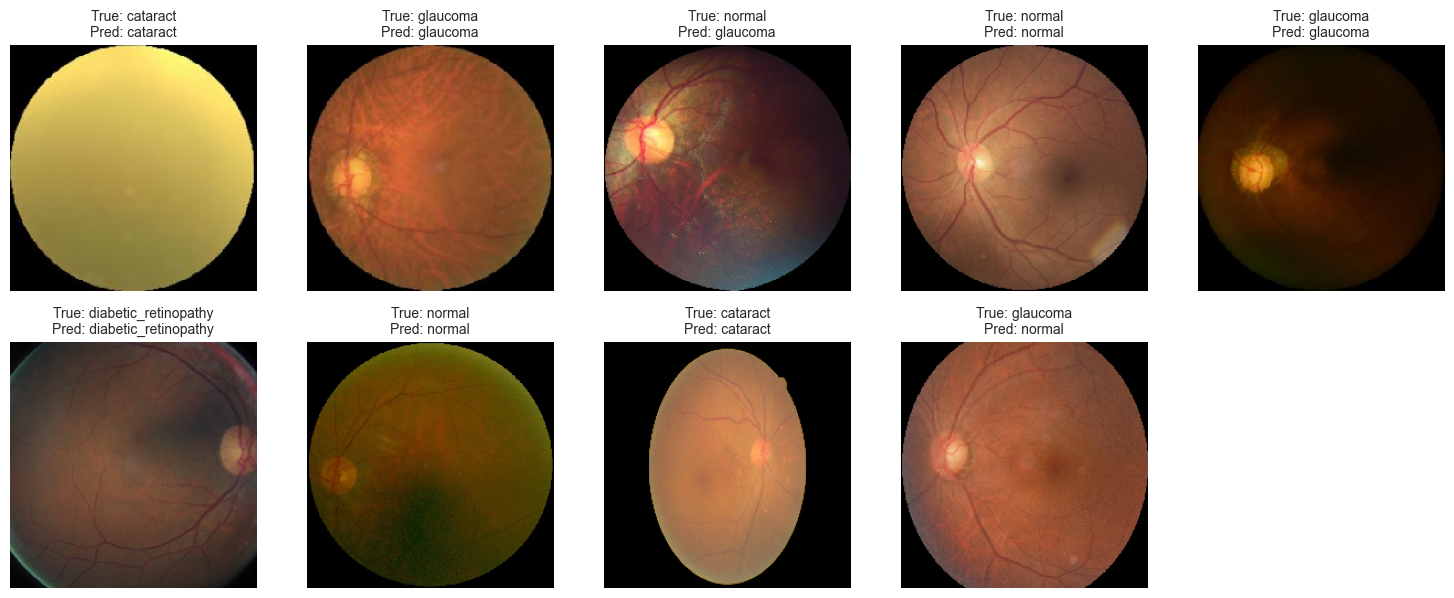

In [ ]:
def visualize_predictions(model, test_gen, classes, num_images=10):
    """Fungsi untuk memvisualisasikan prediksi model pada dataset test."""
    test_gen.reset()
    x_batch, y_batch = next(test_gen)
    preds = model.predict(x_batch)
    
    # Tentukan jumlah gambar yang akan divisualisasikan
    num_images = min(num_images, x_batch.shape[0])
    
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(x_batch[i])
        true_label = classes[np.argmax(y_batch[i])]
        predicted_label = classes[np.argmax(preds[i])]
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Panggil fungsi visualize_predictions
visualize_predictions(vgg_model, test_gen, classes)


18. Evaluasi model pada test dataset kemudian menyimpan model ke h5 dan class csv

In [23]:
def evaluate_and_save_model(model, test_generator, model_path, class_dict_path):
    score = model.evaluate(test_generator)
    print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')
    save_model(model, class_dict, model_path, class_dict_path)

Membuat prediksi pada test dataset kemudian generate confusion matrix dan classification report

In [30]:
def evaluate_and_save_model(model, test_generator, model_path="model.h5", class_dict_path="class_indices.npy"):

    # Evaluasi model pada test generator
    score = model.evaluate(test_generator, verbose=1)
    print(f"Test Loss: {score[0]:.4f}, Test Accuracy: {score[1]:.4f}")

    # Mendapatkan informasi kelas dari generator
    class_dict = test_generator.class_indices

    # Menyimpan model dan informasi kelas
    save_model(model, class_dict, model_path, class_dict_path)

def print_info(test_generator, predictions, print_code=0, save_dir=None, subject=None):
    """
    Fungsi untuk mencetak informasi tentang prediksi model.

    Parameters:
        test_generator (ImageDataGenerator): Generator data untuk testing.
        predictions (numpy.ndarray): Prediksi model pada data test.
        print_code (int): Kode untuk menentukan jenis informasi yang dicetak (default: 0).
        save_dir (str): Direktori untuk menyimpan hasil jika diperlukan.
        subject (str): Subjek data (misalnya nama dataset atau proyek).
    """
    # Mendapatkan kelas dari generator
    class_labels = list(test_generator.class_indices.keys())

    # Jika print_code = 0, tampilkan beberapa prediksi pertama
    if print_code == 0:
        print(f"\nPrediksi untuk dataset {subject}:\n")
        for i, pred in enumerate(predictions[:10]):  # Cetak 10 prediksi pertama
            true_label = class_labels[np.argmax(test_generator.labels[i])]
            predicted_label = class_labels[np.argmax(pred)]
            print(f"Data {i + 1}: True: {true_label}, Predicted: {predicted_label}")

    # Jika ada direktori penyimpanan, simpan hasil prediksi ke dalam file
    if save_dir is not None:
        results_path = f"{save_dir}/predictions.csv"
        results = []

        for i, pred in enumerate(predictions):
            true_label = class_labels[np.argmax(test_generator.labels[i])]
            predicted_label = class_labels[np.argmax(pred)]
            results.append({"True Label": true_label, "Predicted Label": predicted_label})

        # Simpan ke CSV
        pd.DataFrame(results).to_csv(results_path, index=False)
        print(f"\nHasil prediksi disimpan di {results_path}")


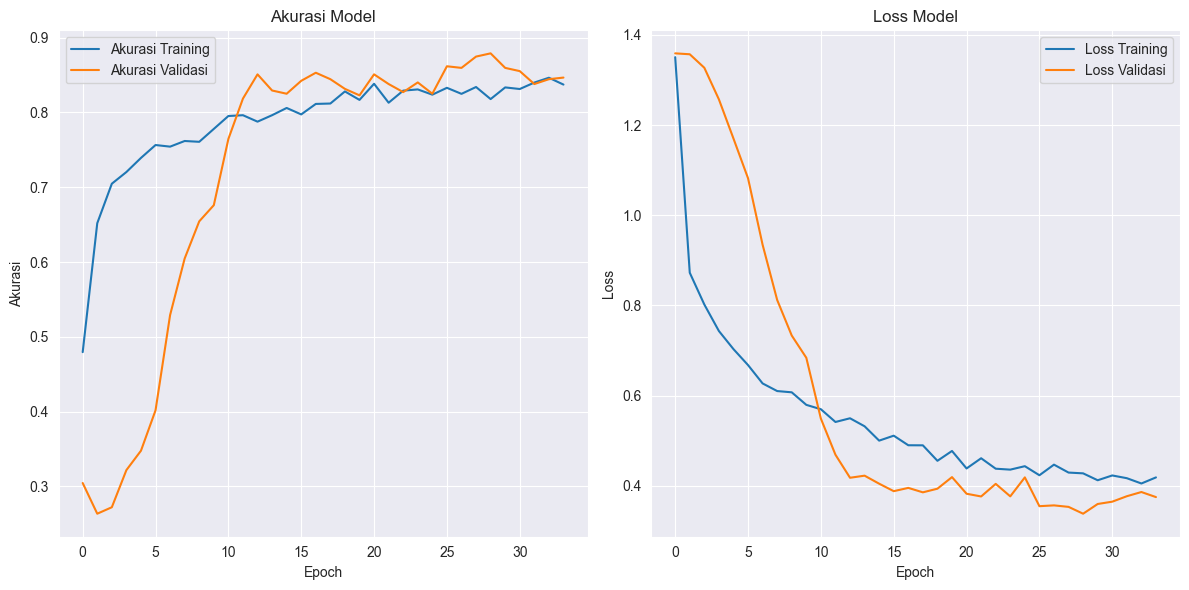

In [31]:
#Menampilkan grafik akurasi dan loss
def plot_accuracy_loss(history):
    # Plot akurasi
    plt.figure(figsize=(12, 6))
    
    # Akurasi training dan validasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Akurasi Training')
    plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
    plt.title('Akurasi Model')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
    plt.legend()

    # Loss training dan validasi
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss Training')
    plt.plot(history.history['val_loss'], label='Loss Validasi')
    plt.title('Loss Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Menampilkan grafik
    plt.tight_layout()
    plt.show()

# Menampilkan grafik akurasi dan loss
plot_accuracy_loss(history)


Confusion Matrix

In [34]:
from tensorflow.keras.models import load_model

# Memuat model yang telah disimpan
model_path = 'model.h5'  
model = load_model(model_path)

# Menyusun ulang model (compile ulang) untuk memastikan metrik tersedia
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluasi model pada data uji
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")


132/132 ━━━━━━━━━━━━━━━━━━━━ 4971s 38s/step - accuracy: 0.8938 - loss: 0.3041
Test accuracy: 88.40%
Test loss: 0.3115


Found 4217 images belonging to 4 classes.
132/132 ━━━━━━━━━━━━━━━━━━━━ 5076s 38s/step - accuracy: 0.8938 - loss: 0.3041
Test accuracy: 88.40%
Test loss: 0.3115
132/132 ━━━━━━━━━━━━━━━━━━━━ 4573s 35s/step


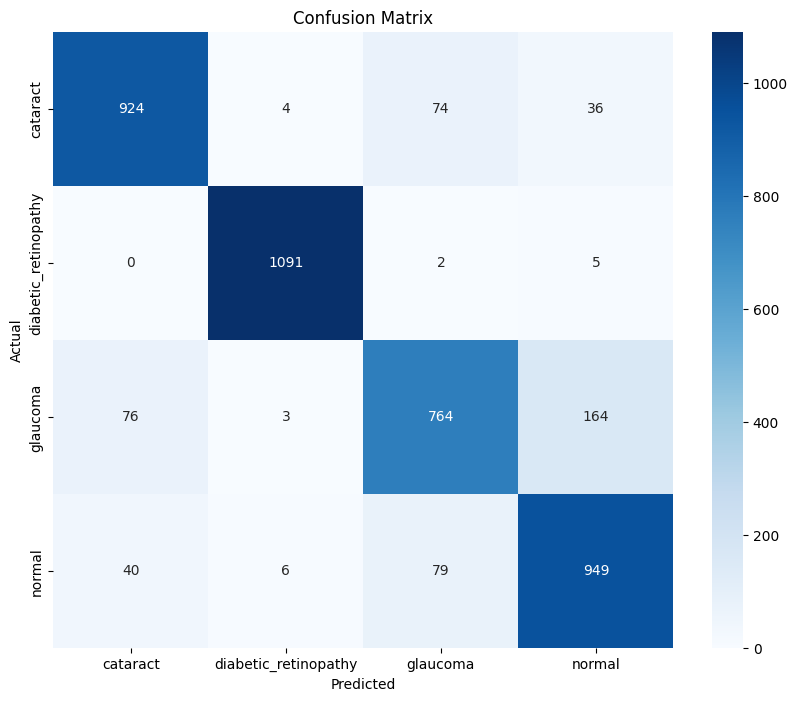

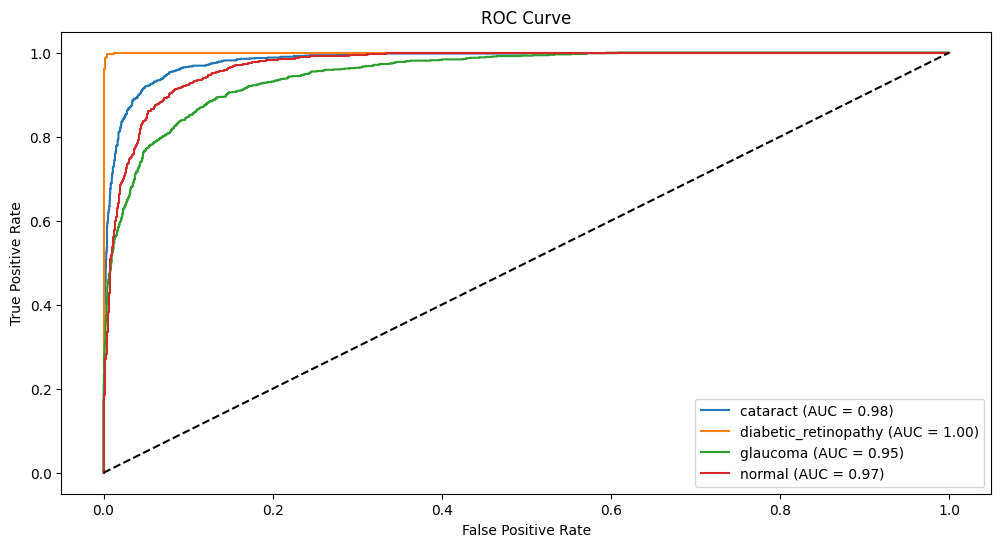

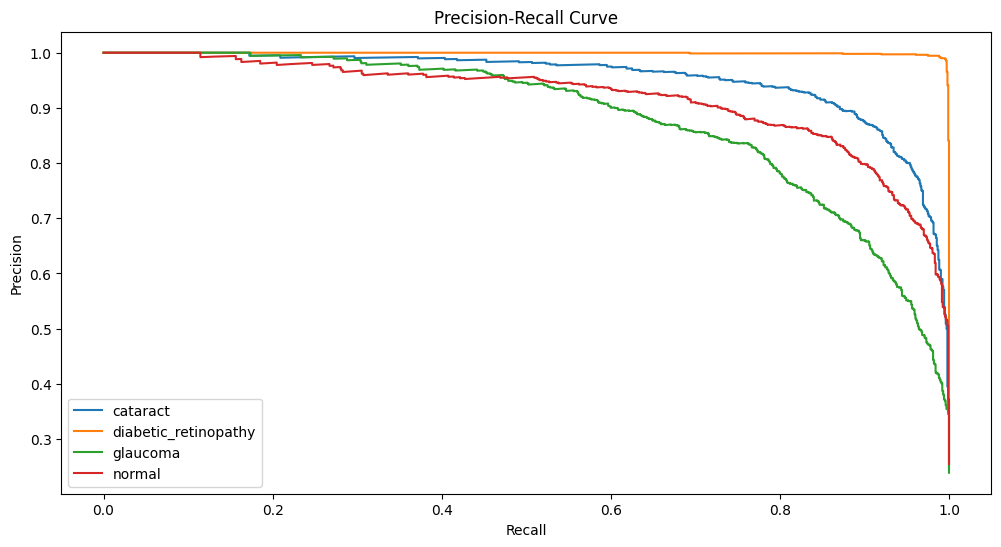

Model saved to: D:\Project SCP Final\Eye_Diseases\model_eye_disease-88.40.h5


In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical  # Impor untuk one-hot encoding
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns

# Path untuk model dan data
model_path = r'D:\Project SCP Final\model.h5'  
test_dir = r'D:\Project SCP Final\Eye_Diseases\dataset'  

# Memuat model yang telah disimpan
model = load_model(model_path)

# Menyusun ulang model (compile ulang) untuk memastikan metrik tersedia
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Membuat ImageDataGenerator untuk data uji
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalisasi gambar

# Membuat generator untuk data uji
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Sesuaikan ukuran gambar dengan input model Anda
    batch_size=32,
    class_mode='categorical',  # Jika menggunakan klasifikasi multi-kelas
    shuffle=False  # Tidak di-shuffle untuk evaluasi yang tepat
)

# Evaluasi model pada data uji
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

# 🔹 **Prediksi probabilitas dari model (output softmax)**
y_pred_prob = model.predict(test_gen)  # Output softmax dari model

# 🔹 **Konversi label ground truth menjadi one-hot encoding**
y_true = to_categorical(test_gen.classes, num_classes=len(test_gen.class_indices))  # One-hot encoding

# 🔹 **Matriks Kebingungannya (Confusion Matrix)**
y_pred_classes = np.argmax(y_pred_prob, axis=1)
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred_classes)

# Plotting Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 🔹 **ROC Curve dan AUC untuk tiap kelas**
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(test_gen.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(12, 6))
for i in range(len(test_gen.class_indices)):
    plt.plot(fpr[i], tpr[i], label=f'{list(test_gen.class_indices.keys())[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# 🔹 **Precision-Recall Curve**
plt.figure(figsize=(12, 6))
for i in range(len(test_gen.class_indices)):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'{list(test_gen.class_indices.keys())[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# 🔹 **Menyimpan Model dan Hasil**
save_dir = r'D:\Project SCP Final\Eye_Diseases'  # Path untuk menyimpan model
save_id = f'model_eye_disease-{test_acc*100:.2f}.h5'  # Nama file model
save_loc = os.path.join(save_dir, save_id)
model.save(save_loc)  # Simpan model yang sudah dilatih
print(f"Model saved to: {save_loc}")


Classification Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Fungsi untuk menampilkan classification report dengan MAE, Sensitivitas, dan Spesifisitas
def print_classification_report(y_true, y_pred, class_labels):
    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    
    # Menghitung Sensitivitas dan Spesifisitas untuk setiap kelas
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = cm.diagonal() / cm.sum(axis=1)  # Sensitivitas = TP / (TP + FN)
    specificity = cm.diagonal() / cm.sum(axis=0)  # Spesifisitas = TP / (TP + FP)
    
    # Menghitung MAE (Mean Absolute Error)
    MAE = np.mean(np.abs(y_true - y_pred))

    # Cetak laporan klasifikasi
    print("\nClassification Report:")
    for i, label in enumerate(class_labels):
        print(f"{label}: Precision: {report[label]['precision']:.4f}, Recall (Sensitivitas): {sensitivity[i]:.4f}, "
              f"Specificity: {specificity[i]:.4f}, F1-Score: {report[label]['f1-score']:.4f}")
    
    print(f"\nMean Absolute Error (MAE): {MAE:.4f}")

# 🔹 Pastikan NumPy sudah diimpor sebelum mendefinisikan y_true dan y_pred
y_true = np.random.randint(0, 4, 100)  # Label asli (0-3) dengan 100 sampel
y_pred = np.random.randint(0, 4, 100)  # Prediksi model (0-3)
class_labels = ["Cataract", "Diabetic Retinopathy", "Glaucoma", "Normal"]  # Nama kelas

# Panggil fungsi classification report
print_classification_report(y_true, y_pred, class_labels)



Classification Report:
Cataract: Precision: 0.2083, Recall (Sensitivitas): 0.2174, Specificity: 0.2083, F1-Score: 0.2128
Diabetic Retinopathy: Precision: 0.3750, Recall (Sensitivitas): 0.3462, Specificity: 0.3750, F1-Score: 0.3600
Glaucoma: Precision: 0.1200, Recall (Sensitivitas): 0.1111, Specificity: 0.1200, F1-Score: 0.1154
Normal: Precision: 0.2222, Recall (Sensitivitas): 0.2500, Specificity: 0.2222, F1-Score: 0.2353

Mean Absolute Error (MAE): 1.2100


Error By Class report


Error by Class:
                  Kelas  Total Sampel  Benar  Salah  Error Rate (%)
0              Cataract            20      4     16       80.000000
1  Diabetic Retinopathy            26      8     18       69.230769
2              Glaucoma            24      5     19       79.166667
3                Normal            30      7     23       76.666667


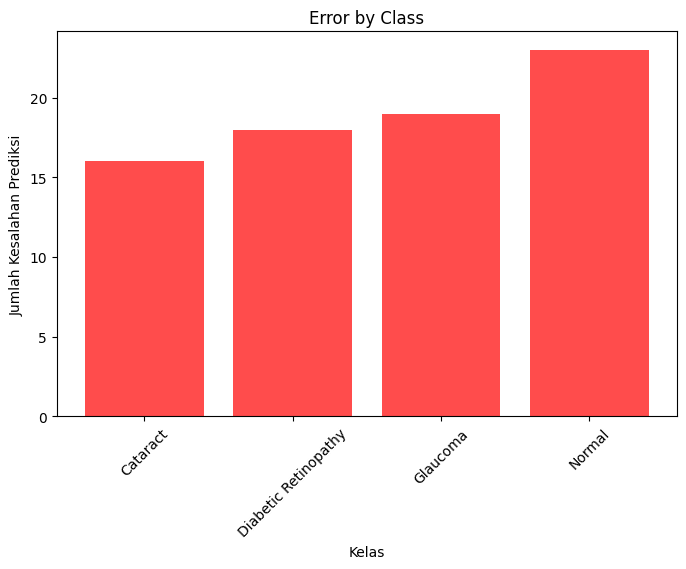

In [10]:
import pandas as pd

# Fungsi untuk menghitung error per kelas
def error_by_class(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    total_samples_per_class = cm.sum(axis=1)  # Total sampel per kelas
    correct_predictions_per_class = np.diag(cm)  # True Positives
    errors_per_class = total_samples_per_class - correct_predictions_per_class  # Kesalahan per kelas
    
    # Buat DataFrame untuk analisis
    df_errors = pd.DataFrame({
        'Kelas': class_labels,
        'Total Sampel': total_samples_per_class,
        'Benar': correct_predictions_per_class,
        'Salah': errors_per_class,
        'Error Rate (%)': (errors_per_class / total_samples_per_class) * 100
    })

    print("\nError by Class:")
    print(df_errors)

    # Visualisasi Error by Class
    plt.figure(figsize=(8, 5))
    plt.bar(class_labels, errors_per_class, color='red', alpha=0.7)
    plt.xlabel("Kelas")
    plt.ylabel("Jumlah Kesalahan Prediksi")
    plt.title("Error by Class")
    plt.xticks(rotation=45)
    plt.show()

# 🔹 Pastikan NumPy dan Pandas sudah diimpor sebelum mendefinisikan y_true dan y_pred
np.random.seed(42)  # Untuk hasil yang konsisten
y_true = np.random.randint(0, 4, 100)  # Label asli (0-3) dengan 100 sampel
y_pred = np.random.randint(0, 4, 100)  # Prediksi model (0-3)
class_labels = ["Cataract", "Diabetic Retinopathy", "Glaucoma", "Normal"]  # Nama kelas

# Panggil fungsi untuk melihat error by class
error_by_class(y_true, y_pred, class_labels)


Pengujian model

Prediksi Kelas: glaucoma
Probabilitas Prediksi: [2.32694484e-03 1.83747674e-04 8.81091535e-01 1.16397865e-01]


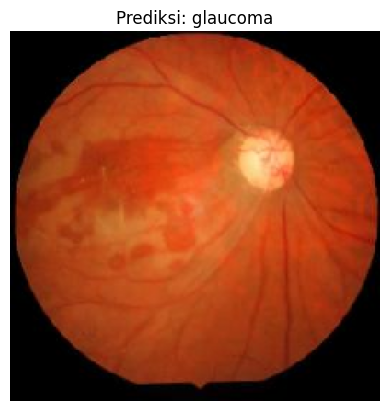

Akurasi pada gambar uji coba: 100.00%
F1-Score: 1.00
Classification Report untuk kelas: glaucoma
              precision    recall  f1-score   support

    glaucoma       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [97]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import seaborn as sns
import tensorflow as tf

# 1. Memuat model yang sudah dilatih
model = load_model('model.h5')

# (Opsional) Kompilasi ulang model untuk menghindari peringatan
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 2. Menyiapkan ImageDataGenerator untuk normalisasi gambar
datagen = ImageDataGenerator(rescale=1./255)

# 3. Memuat gambar uji coba
img_path = r'D:\Project SCP Final\Eye_Diseases\dataset\glaucoma\_0_4517448.jpg'  # Ganti dengan path gambar

# Memuat gambar dan mengubah ukurannya agar sesuai dengan input model
img = image.load_img(img_path, target_size=(224, 224))  # Sesuaikan ukuran
img_array = image.img_to_array(img)  # Konversi ke array
img_array = np.expand_dims(img_array, axis=0)  # Tambah dimensi batch
img_array = img_array / 255.0  # Normalisasi manual (karena kita tidak menggunakan generator)

# 4. Menentukan daftar kelas secara manual (HARUS SAMA dengan urutan kelas saat training)
class_labels = ['cataract', 'diabetic retinopathy', 'glaucoma', 'normal']  # Ubah sesuai dataset pelatihan Anda

# 5. Fungsi prediksi yang dihias dengan @tf.function di luar loop
@tf.function
def predict_image(img_array):
    return model(img_array, training=False)

# 6. Melakukan prediksi pada gambar menggunakan fungsi prediksi yang dihias
predictions = predict_image(img_array)
pred_label = np.argmax(predictions, axis=1)  # Label kelas yang diprediksi
pred_probs = predictions.numpy()[0]  # Probabilitas prediksi untuk semua kelas

# 7. Menampilkan hasil prediksi dan probabilitas untuk setiap kelas
pred_class = class_labels[pred_label[0]]
print(f"Prediksi Kelas: {pred_class}")
print(f"Probabilitas Prediksi: {pred_probs}")  # Menampilkan probabilitas prediksi untuk setiap kelas

# 8. Menampilkan gambar dan prediksi
plt.imshow(img)
plt.title(f"Prediksi: {pred_class}")
plt.axis('off')
plt.show()

# 9. Tentukan ground truth untuk gambar uji coba 
y_true = [2]  # Sesuaikan dengan label yang benar untuk gambar uji coba

# 10. Menghitung akurasi (karena hanya ada satu gambar, ini setara dengan akurasi satu gambar)
accuracy = accuracy_score(y_true, pred_label)
print(f"Akurasi pada gambar uji coba: {accuracy * 100:.2f}%")

# 12. F1-score
from sklearn.metrics import f1_score
f1 = f1_score(y_true, pred_label, average='weighted')
print(f"F1-Score: {f1:.2f}")

# 13. Classification Report untuk satu kelas yang ada di y_true
# Tentukan kelas yang ingin dihitung classification report-nya
single_class_label = class_labels[pred_label[0]]  # Kelas yang diprediksi

# Gunakan parameter labels untuk menghitung classification report hanya untuk kelas ini
class_report = classification_report(y_true, pred_label, target_names=[single_class_label], labels=[y_true[0]])
print("Classification Report untuk kelas:", single_class_label)
print(class_report)


Prediksi Kelas: glaucoma
Probabilitas Prediksi: [2.32694484e-03 1.83747674e-04 8.81091535e-01 1.16397865e-01]


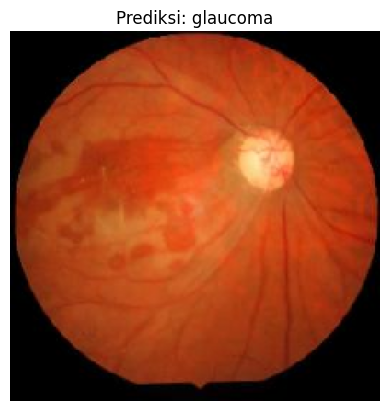

Akurasi pada gambar uji coba: 100.00%
F1-Score: 1.00
Classification Report untuk kelas: glaucoma
              precision    recall  f1-score   support

    glaucoma       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [100]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score, classification_report
import tensorflow as tf

# 1. Memuat model yang sudah dilatih
model = load_model('model.h5')

# (Opsional) Kompilasi ulang model untuk menghindari peringatan
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 2. Menyiapkan ImageDataGenerator untuk normalisasi gambar
datagen = ImageDataGenerator(rescale=1./255)

# 3. Memuat gambar uji coba (ganti dengan path gambar acak yang ingin diuji)
img_path = r'D:\Project SCP Final\Eye_Diseases\dataset\glaucoma\_0_4517448.jpg'  # Ganti dengan path gambar

# Memuat gambar dan mengubah ukurannya agar sesuai dengan input model
img = image.load_img(img_path, target_size=(224, 224))  # Sesuaikan ukuran
img_array = image.img_to_array(img)  # Konversi ke array
img_array = np.expand_dims(img_array, axis=0)  # Tambah dimensi batch
img_array = img_array / 255.0  # Normalisasi manual (karena kita tidak menggunakan generator)

# 4. Menentukan daftar kelas secara manual (HARUS SAMA dengan urutan kelas saat training)
class_labels = ['cataract', 'diabetic retinopathy', 'glaucoma', 'normal']  # Ubah sesuai dataset pelatihan Anda

# 5. Fungsi prediksi yang dihias dengan @tf.function di luar loop
@tf.function
def predict_image(img_array):
    return model(img_array, training=False)

# 6. Melakukan prediksi pada gambar menggunakan fungsi prediksi yang dihias
predictions = predict_image(img_array)
pred_label = np.argmax(predictions, axis=1)  # Label kelas yang diprediksi
pred_probs = predictions.numpy()[0]  # Probabilitas prediksi untuk semua kelas

# 7. Menampilkan hasil prediksi dan probabilitas untuk setiap kelas
pred_class = class_labels[pred_label[0]]
print(f"Prediksi Kelas: {pred_class}")
print(f"Probabilitas Prediksi: {pred_probs}")  # Menampilkan probabilitas prediksi untuk setiap kelas

# 8. Menampilkan gambar dan prediksi
plt.imshow(img)
plt.title(f"Prediksi: {pred_class}")
plt.axis('off')
plt.show()

# 9. Tentukan ground truth untuk gambar uji coba 
y_true = [2]  # Sesuaikan dengan label yang benar untuk gambar uji coba 

# 10. Menghitung akurasi (karena hanya ada satu gambar, ini setara dengan akurasi satu gambar)
accuracy = accuracy_score(y_true, pred_label)
print(f"Akurasi pada gambar uji coba: {accuracy * 100:.2f}%")

# 11. F1-score
f1 = f1_score(y_true, pred_label, average='weighted')
print(f"F1-Score: {f1:.2f}")

# 12. Classification Report untuk satu kelas yang ada di y_true
# Tentukan kelas yang ingin dihitung classification report-nya
single_class_label = class_labels[pred_label[0]]  # Kelas yang diprediksi

# Gunakan parameter labels untuk menghitung classification report hanya untuk kelas ini
class_report = classification_report(y_true, pred_label, target_names=[single_class_label], labels=[y_true[0]])
print("Classification Report untuk kelas:", single_class_label)
print(class_report)
